# Breast Cancer Diagnosis 

<div class="alert alert-block alert-info">

## Management Summary

### Purpose of the exercise

This exercise is intended to classify cells in microscope slides from breast cancer biopsies as cancerous of benign.

### Utility of the exercise

This exercise will explore the use of machine learning algorithms to improve diagnoses of cancer cells, thus reduce unnecessary patient anxiety and minimizing costs for further diagnostic testing that occur as a result of misdiagnosis. Additionally, to provide proof of concept for integration of kdb and python machine learning libraries. 

### Dataset Characteristics

We'll be using the dataset for "Breast Cancer Wisconsin (Diagnostic) Data Set" available from [Kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)

### Predictors to be used

The following 10 nuclei descriptors will be used as an input to the ML functions:

Radius, texture, perimeter, area, smoothness, compactness, concase points, concavity, symmetry and fractal dimension

### Tools used

We'll be using the following tools for the exercise:

> **KDB+**: [http://www.kx.com](http://www.kx.com "kdb+")

> **Python (Anaconda)**: [https://anaconda.org](https://anaconda.org "Python Anaconda")

> **jupyterq**: [https://github.com/KxSystems/jupyterq](https://github.com/KxSystems/jupyterq "jupyterq")

> **scikit-learn**: [http://scikit-learn.org/stable/](http://scikit-learn.org/stable/ "scikit-learn")


## Contents

1. Data Preparation
    - 1.1 Data Import and load
    - 1.2 Data Formatting
    - 1.3 Data Visualization
    - 1.4 Feature Scaling
2. Dimensionality Reduction 
    - 2.1 PCA Implementation and Visualization
    - 2.2 Applying PCA
3. Clustering 
    - 3.1 Creating Clusters 
    - 3.2 Cluster Visualization
    - 3.3 Clustering: Conclusion and Next steps
4. SVM
    - 4.1 Prepare Training and test sets
    - 4.2 Model fitting and gridsearch
    - 4.3 Model evaluation and visualization
5. Conclusion and Next Steps
6. References

## Background

Breast cancer is one of the leading causes of death for woman worldwide, with an average of 252,710 woman diagnosed per year in the United States [1](http://www.nationalbreastcancer.org/breast-cancer-facts). Mammography and Fine Needle Aspiration (FNA) biopsy are common techniques used to detect breast tissue abnormalities and distinguish between harmless and life threatening irregularities to determine treatment requirements. Mammography misdiagnosis rates can be as high as 12% [2](https://ww5.komen.org/BreastCancer/AccuracyofMammograms.html) while FNA can fail to differentiate between life threatening and non-life threatening cancers as much as 25% of the time [3](https://dollar.biz.uiowa.edu/~street/research/cc97_02.pdf). Sample cells obtained from FNA are examined by microscope in a pathology laboratory and numerical features such as cell radius, texture and more are calculated. Physicians than use the FNA and other imaging results to predict the probability that cells are cancerous. Misdiagnosis brings unneeded anxiety to patients and cost to the healthcare system. Additionally, analysis of FNA slides can be labour and resource intensive, thus automating the process could be advantageous for healthcare resources.


This notebook will explore the use of Machine Learning algorithms to distinguish between benign and malignant cancer cells seen in digital scans of FNA slides, with hopes of improving breast cancer prognostic estimations. Two machine learning models will be explored, unsupervised clustering and support vector machines (SVM). 


## The Data

The data consists of FNA results from 569 patients, 212 with cancer and 357 with benign masses. This data was augmented by 10 000 rows to demonstrate the integration of python machine learning libraries with large kdb+ data sets. 

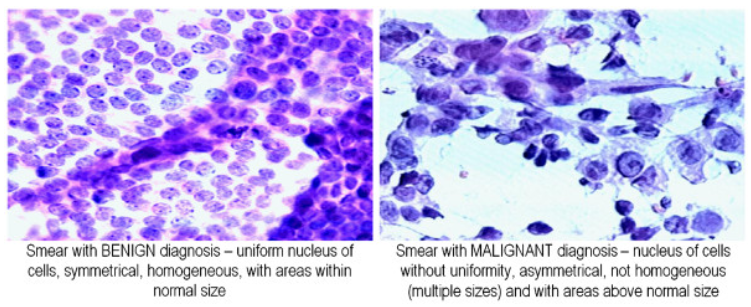
[4](https://www.linkedin.com/pulse/using-k-means-clustering-tableau-diagnose-breast-cancer-mayand-tiwari/)


## Machine Learning Algorithms


### Clustering 

Clustering is a method of unsupervised machine learning used to reveal hidden structures or groupings in large datasets. Object clusters are generated based on correspondence between features, quantified using a distance function. This results in a set of clusters where objects within a cluster are further similar to each other than to objects in another cluster. Clustering analysis has been used broadly, from image segmentation and processing, data analysis and pattern recognition [5](https://pdfs.semanticscholar.org/137d/bb50b86299b07a0c630fde249b30e8518c58.pdf).

### Support Vector Machines

Support Vector Machines is a type of supervised learning commonly used for high dimensional binary classification problems. Support Vector Machine separates data into classes by identifying a hyperplane function that maximizes the separation, or margin, between classes. After training data is used to create the model, additional data points can be assigned a class based on where they lie in the feature space with respect to the hyperplane. SVMs are widely used; applications include image classification, face detection and bioinformatics.

# 1. Data Preperation
## 1.1 Data Import and Load

** Import data from Kaggle ** <br/>

Data was imported from Kaggle as a csv file and reformatted to a kdb+ table with the following:

#### 1. In a putty window, navigate to the directory where you wish to import the csv file and enter the following unix commands:   

```
wget https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/data.csv
mv data.csv bc_data.csv ```

#### 2. Open a q session and run the following lines:
```
/import csv file, specify column types
data: ("JSFFFFFFFFFF";enlist(",")) 0: `:bc_data.csv

newcols:`id`diagnosis`radius_mean`texture_mean`perimeter_mean`area_mean`smoothness_mean`compactness_mean`concavity_mean`concave_points_mean`symmetry_mean`fractal_dimension_mean       

/rename columns to correct typos
newcols xcol data;  

/save table as splayed
`:/home/erin/bc_data/data/ set .Q.en[``:bc_data]  data

```


** Import data and the required libraries**

In [3]:
\c 200 500

.p.repr

{[h;x]$[i.isf x;h x;i.isw x;h x`.;i.isc x;h x{get[x]y}/1 0 1 1;"no help available"]}[code[code;]{enlist x}]


In [1]:
np:.p.import `numpy
.p.repr np[`:array][1 2 3]

"array([1, 2, 3])"


In [9]:
\l /home/erin/bc_data_b
\l /home/erin/funcs.q       
\l /home/erin/Graphics.q
\l /home/erin/visuals.q

np:.p.import`numpy                              // import numpy for math
plt:.p.import`matplotlib.pyplot                // import library for plotting

**Display Data** <br/>

Described features include patient descriptions - diagnosis (Benign/Malignant) and record id - and 10 nuclei descriptors - radius, texture, perimeter, area, smoothness, compactness, concave points, concavity, symmetry and fractal dimension. The first 3 rows of each data column are shown below.

The 10 nuclei descriptors will be used as predictors well diagnosis is out target variable. 

In [10]:
\c 200 200
getcols:{ c:(),x; ?[`data; (); 0b; c!c]}
3# getcols (cols data)[til 7]
3# getcols (cols data)[7+til 5]

id       diagnosis radius_mean texture_mean perimeter_mean area_mean smoothness_mean
------------------------------------------------------------------------------------
842302   M         17.99       10.38        122.8          1001      0.1184         
842517   M         20.57       17.77        132.9          1326      0.08474        
84300903 M         19.69       21.25        130            1203      0.1096         


compactness_mean concavity_mean concave points_mean symmetry_mean fractal_dimension_mean
----------------------------------------------------------------------------------------
0.2776           0.3001         0.1471              0.2419        0.07871               
0.07864          0.0869         0.07017             0.1812        0.05667               
0.1599           0.1974         0.1279              0.2069        0.05999               


**Get shape of data**

In [11]:
-1"Shape of features is "," x " sv string shape data;

Shape of features is 10000 x 12


## 1.2 Data Formatting

**Unenumerate columns**

In [12]:
ecols: (cols data)[where (type each data[cols data]) within 6 76]
update diagnosis:value data`diagnosis from `data; // format data for scaling

**Create numeric diagnosis column**

In [13]:
// Encode Benign and Malignant as 0 and 1 respectively 
update Diagnosis_Encode: data[`diagnosis] from `data;
update Diagnosis_Encode:`0 from `data where Diagnosis_Encode=`B;
update Diagnosis_Encode:`1 from `data where Diagnosis_Encode=`M;
update Diagnosis_Encode:"I"$(string Diagnosis_Encode) from `data;

## 1.3 Data Visualization 

A scatter matrix can be used to examine correlation between the 10 predictors and identify outliers.

In [14]:
data_hist: delete Diagnosis_Encode from data   // drop columns that are not input parmeters 
datadf_hist:tab2df data_hist                                  // convert data to pandas data matrix for plotting

**Heat Map Illustrating Data Correlation**

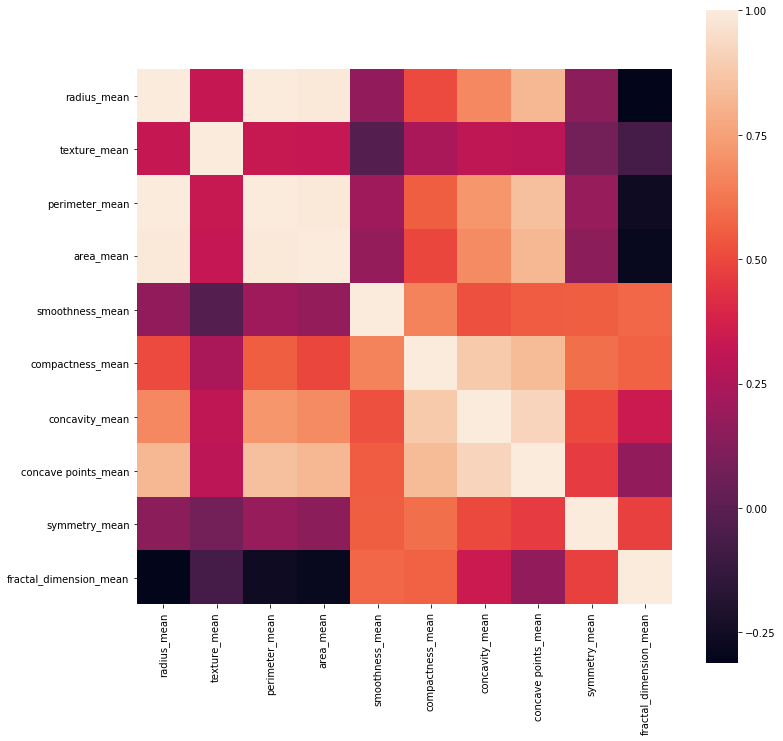

In [15]:
sns: .p.import `seaborn
data_f: delete id,diagnosis,Diagnosis_Encode from data   // drop columns that are not input parmeters 
datadf:tab2df data_f                                     // convert data to pandas data matrix for plotting

plt[`:figure][`figsize pykw 12 12];
corr:datadf[`:corr][];
sns[`:heatmap][corr;`cbar pykw "True";`square pykw "True"];
plt[`:show][];

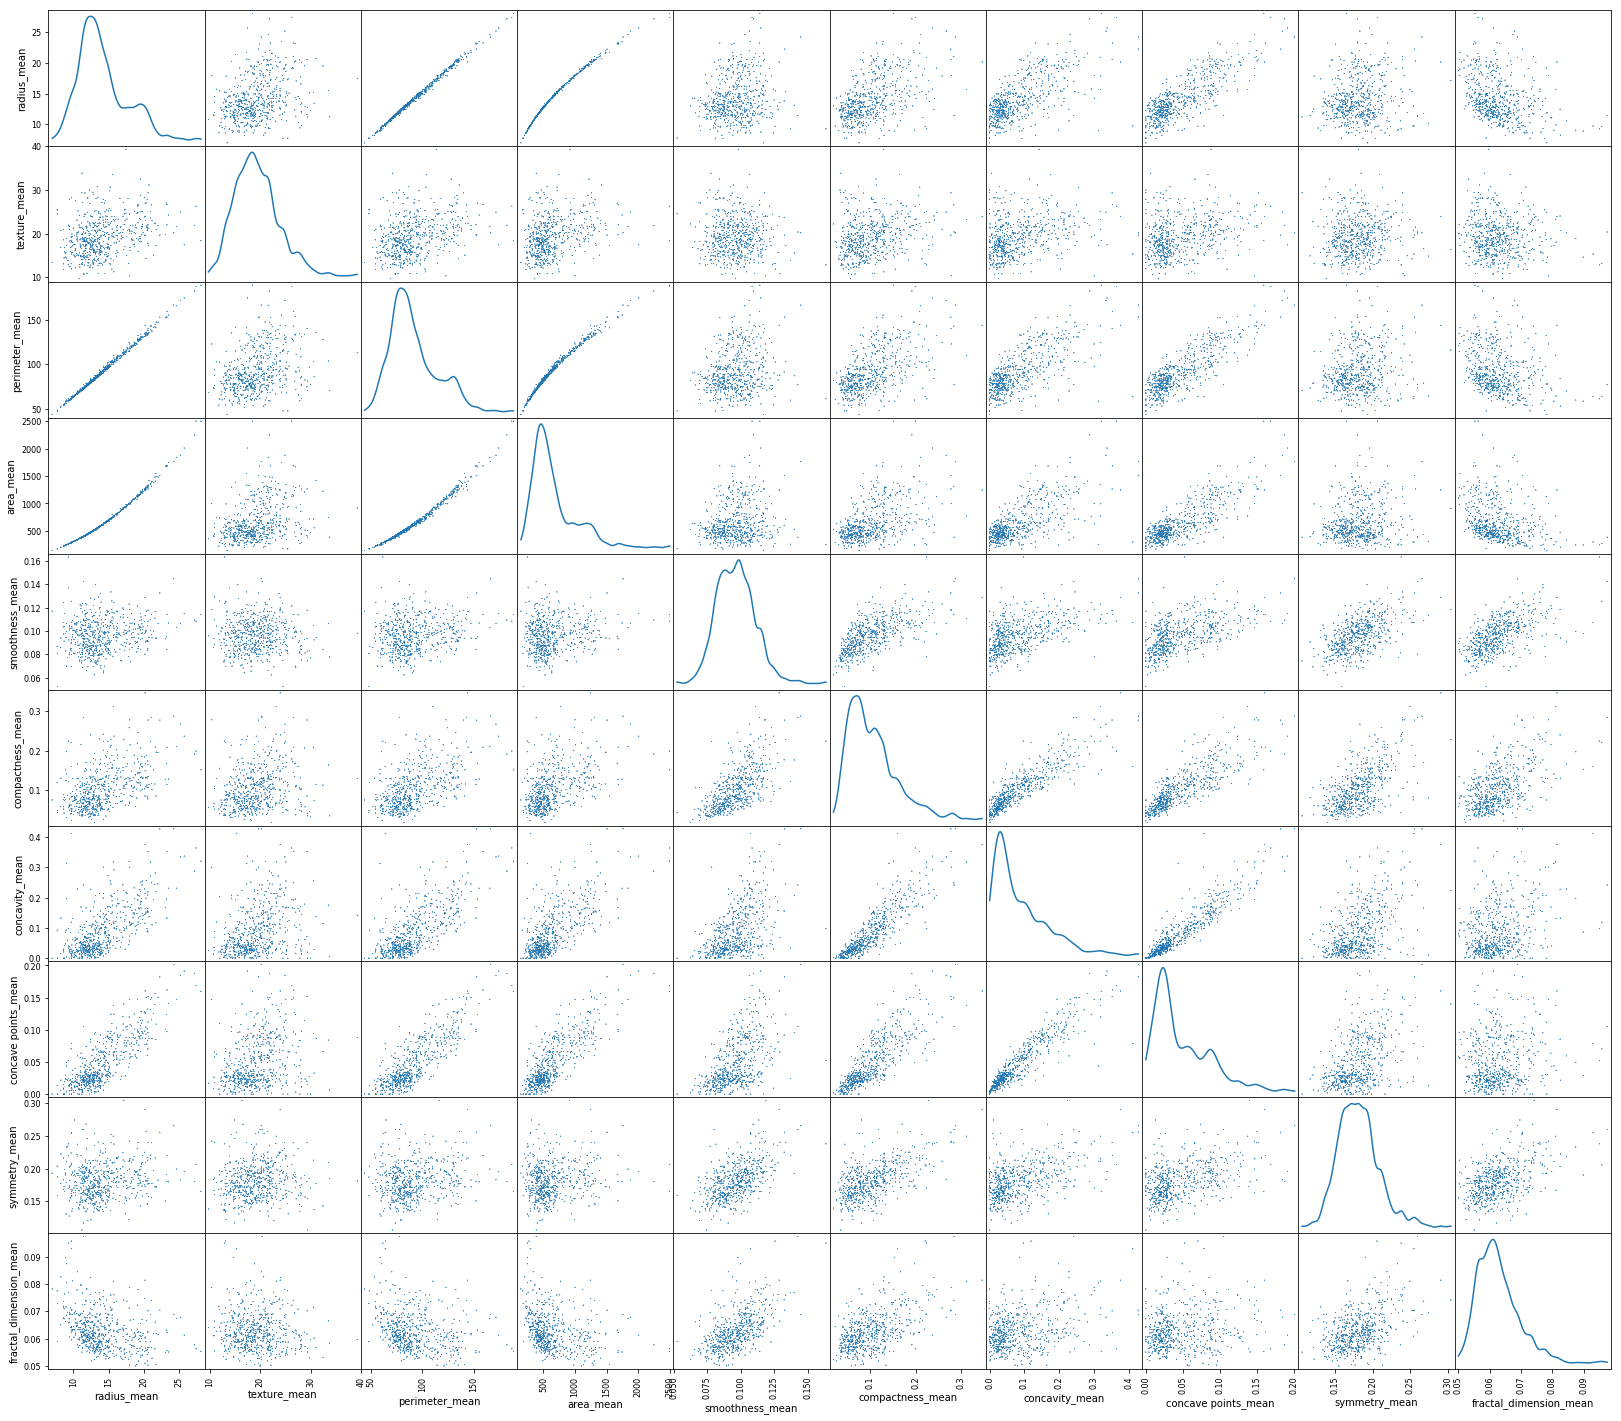

In [35]:
scatter_matrix: pd[`:scatter_matrix][datadf;`alpha pykw 0.3;`figsize pykw 28 25;`diagonal pykw `kde;`s pykw 2];
plt[`:show][];

**Scatter Matrix - Interpretation**

From the plot above, the linear correlation between features such as concavity and concave points become clear. Some relationship are obvious due to the their mathematical derivation (i.e. radius and perimeter). The diagonal of the scatter matrix also allows the data distribution to be explored. 

## 1.4 Feature Scaling

Normalization of data is performed to ensure that all features are weighted equally during clustering.

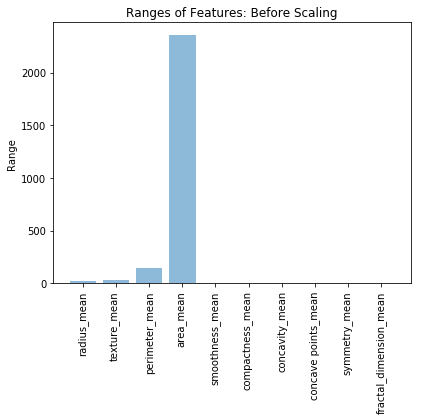

In [16]:
data_cluster: delete id,diagnosis,Diagnosis_Encode from data

range:{max[x]-min x}

xpos:til (count data_cluster 0)
plt[`:bar][xpos; value range data_cluster;`align pykw"center";`alpha pykw 0.5];
plt[`:ylabel]"Range";
plt[`:title]"Ranges of Features: Before Scaling";
plt[`:xticks][np[`:arange][count xpos];cols data_cluster;`rotation pykw "vertical"];
plt[`:show][];

In [30]:
{type data_cluster[x]}each cols data_cluster

9 9 9 9 9 9 9 9 9 9h


In [25]:
minmaxscaler:{{(z-x)%y}[mnx;max[x]-mnx:min x]each x} 

data_scaled:data_cluster
data_scaled:minmaxscaler data_scaled // scale data

# 2. Dimensionality Reduction

Principal component analysis (PCA) is used to reduce the dimensionality of the data by identifying features of maximum variation. PCA is a statistical method allowing key information within a set of data to be summarized and variability between data examined. A set of unique and orthogonal principle components are extracted from the data where the first principle component represents the most variation in the data and each ensuing component represents a decreasing amount of variation.

Identified features can be used as a new way to describe FNA samples, as such, instead of describing each scan by 10 nuclei features, they can be described by 2 or 3 principal components. Reducing the data dimensionality allows the data to be visualized and provides performance gains by decreasing the number of variables that will be required to build ML models. 

### 2.1 PCA Implementation and Visulization

A PCA fit is applied to the 10 nuclei features, generating principal components for the data set. 

The code below implementz the following: 
 - Import `sklearn.decomposition.PCA` 
 - Call ` `:fit `  on the scaled nuclei data to generate principal components.

In [18]:
X: value each data_scaled
PCA:.p.import[`sklearn.decomposition;`:PCA]
PCA_model:PCA[`n_components pykw 5;`whiten pykw 1b];
PCA_model[`:fit;`X pykw X];

The goal of PCA is to reduce the dimensionality of the data, in effect reducing the complexity of the problem. However, it is important to ensure that reducing the data dimensionality does not eliminate necesary variation in the data that allows patients to be differentiated from each other. This can be examined using the by investigating the *cumulative explained variance ratio*.

The table and scree plot below illustrate that the first 2 principal components describe 83% of data variation while 5 principal components describe over 97% of data variation. Thus we will use the first 2 principal components for visulization of data and the first 5 to construct our clustering and SVM models. 

% Variance explained by each principal component


Pricinpal_Component Percent_Variance Cumulative_Variance
--------------------------------------------------------
1                   61.25249         61.25249           
2                   22.01765         83.27014           
3                   7.309314         90.57945           
4                   3.970478         94.54993           
5                   2.69438          97.24431           


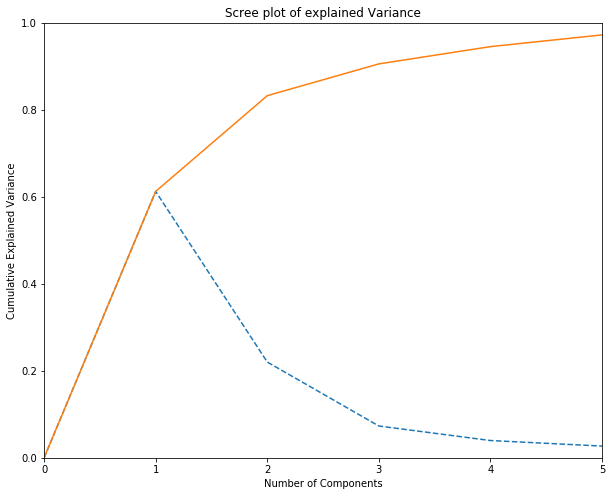

In [47]:
EVR:PCA_model[`:explained_variance_ratio_]`

-1"% Variance explained by each principal component";
([]Pricinpal_Component:`1`2`3`4`5;Percent_Variance: 100*EVR;Cumulative_Variance:100*np[`:cumsum][EVR]` )

screeplot EVR

In the plot below provides a visual representation of the contribution of each of the 10 nuclei features to the first 5 principal components. For example, we see that principal component 3 is strongly related to texture. 

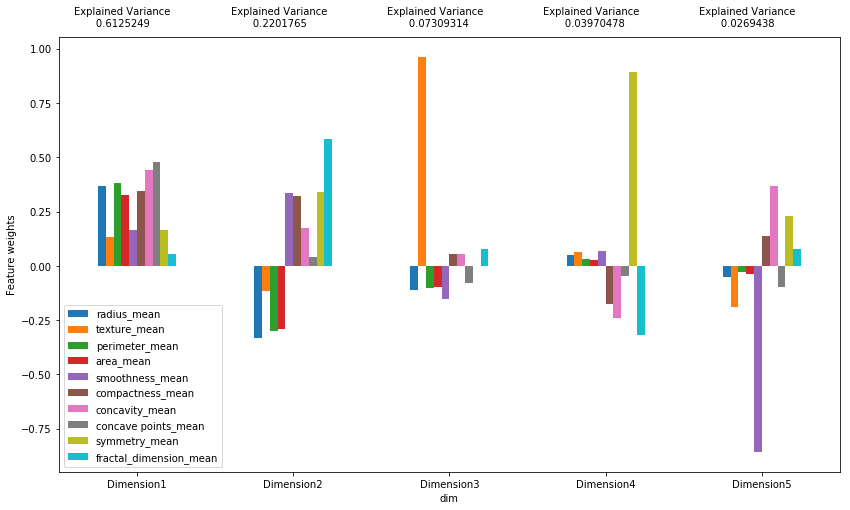

In [48]:
pcaresultsf[data_scaled;PCA_model]

### 2.2 Applying PCA

Once the principal components have been identified, the data can be expressed by the principal components and a principal component score for each record. The code below applies `pca.transform` to generate the principal component scores and reduced dimension data.

In [49]:
x_pca:PCA_model[`:transform][X]`

** Visulizing Dimensionality Reduction: Biplot **

A biplot is a scatterplot where each data point is represented by its principal component scores. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

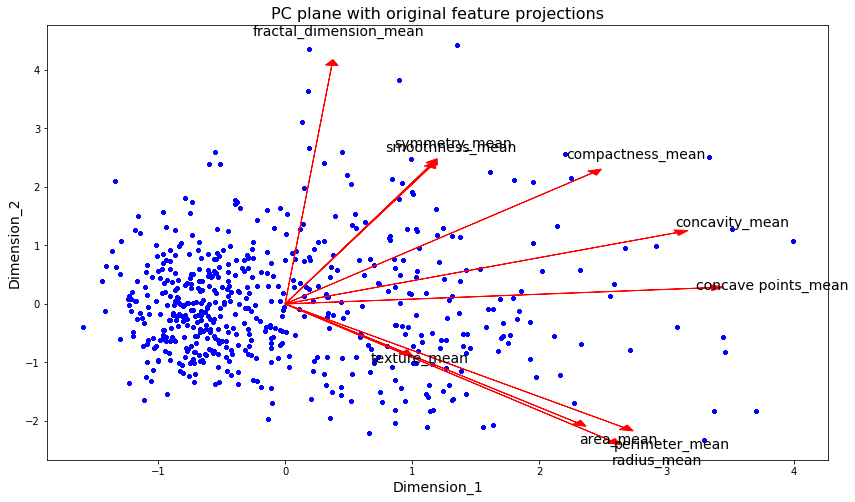

In [50]:
biplot[cols data_scaled;x_pca;PCA_model]

# 3.0 Clustering

## Unsupervised Learning
Machine learning techniques have been traditionally split into two types: supervised and unsupervised techniques. Unsupervised learning algorithms do not use the labels to differentiate instances but they try to differentiate them just based on the features.

## K-Means Clustering

In this section a K-Means clustering algorithm is applied to the dimensionality reduced data to explore exsiting structures in the data and attempt to seperate benign and malignent records. 

The K-Means algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. Mathematically, this is represented by the following:

The K-Means algorithm divides a set of N samples X into K disjoint clusters C, each described by the mean $\mu_j$ of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from X, although they live in the same space. The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum of squared criterion:

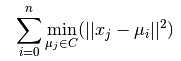

This divides the set of $N$ samples into $C$ disjointed clusters, each descrived by the mean  $\mu_j$ of the samples in the cluster. <br/>

## 3.1 Creating Clusters

For this problem, the desired number of clusters is known - we are looking to seperate the data into benign and malignent groups. 

The code below implements the following: 
- Import `sklearn.clusters`
- Specify k-means parameters: `n_clusters=2`, `init = random`
- Fit the k-means clustering algorithm to dimensionaly reduced data
- Find the cluster centers and labels and assign to variables

In [272]:
Clusters:.p.import[`sklearn.cluster]  
KMeans_PCA:Clusters[`:KMeans;`n_clusters pykw 2;`init pykw "random"]   
\t KMeans_PCA[`:fit][x_pca];                                           
labels_PCA:KMeans_PCA[`:labels_]`                                           
centers_PCA:KMeans_PCA[`:cluster_centers_]`

160


## 3.2 Cluster Visualization

Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

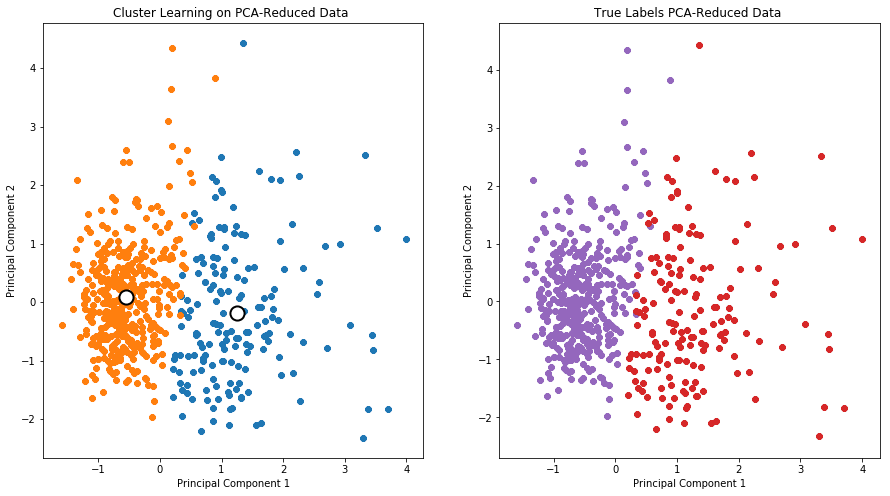

In [117]:
// Plot cluster labels and true labels 
subplots:plt[`:subplots][1;2];
fig:subplots[`:__getitem__]0;
axarr:subplots[`:__getitem__]1;
plot1:axarr[`:__getitem__]0;
plot2:axarr[`:__getitem__]1;

// Color map
cmap:plt[`:cm.get_cmap]"gist_rainbow";
            
fig[`:set_figheight;8];
fig[`:set_figwidth;15];

plot1[`:set_title]"Cluster Learning on PCA-Reduced Data ";
plot1[`:set_xlabel]["Principal Component 1"];
plot1[`:set_ylabel]["Principal Component 2"];
plot2[`:set_title]"True Labels PCA-Reduced Data ";
plot2[`:set_xlabel]["Principal Component 1"];
plot2[`:set_ylabel]["Principal Component 2"];

{i:where labels_PCA=x; plot1[`:scatter;x_pca[i;0];x_pca[i;1];`s pykw 25;`c pykw "C",string x;`marker pykw "o"]}each distinct labels_PCA;

{[i;c;ax]
  plot1[`:scatter][`x pykw c[0];`y pykw c[1];`color pykw `white;`edgecolors pykw `black;`alpha pykw 1;`linewidth pykw 2;`marker pykw `o;`s pykw 200];
 }[;;ax]'[til count centers_PCA;centers_PCA];
  
{i:where labels_PCA=x;plot2[`:scatter;x_pca[i;0];x_pca[i;1];`s pykw 25;`c pykw "C",string (x+3);`marker pykw "o"]}each distinct data`Diagnosis_Encode;
plt[`:show][];

**Cluster Prediction Accuracy**

In [45]:
Cluster_Accuracy:(count where(labels_PCA=data`Diagnosis_Encode))%count labels_PCA
-1"Cluster assignment accuracy is:  ", raze string(Cluster_Accuracy*100)," %";

Cluster assignment accuracy is:  88.23 %


## 3.3 Clustering: Conclusion and Next Steps

Using unsupervised k-means clustering, cancer types were correctly classified 92% of the time. 

A supervised machine learning model will now be used to create a prediction model. 

# 4.Support Vector Machine

### Supervised Learning
Machine learning methods are typically grouped into two categories, supervised and unsupervised. In supervised learning, input variables map to output variables and an algorithm is used to learn the mapping function between input and output. The model is trained using inputs with known outputs, with a goal of predicting the output for inputs with unknown outputs. 
  

### What is an SVM?

Support Vector Machines is a type of supervised learning commonly used for high dimensional binary classification problems. Support Vector Machine seperates data into classes by identifying a hyperplane function that maximizes the seperation, or margin, between classes. After training data is used to create the model, additional data points can be assigned a class based on where they lie in the feature space with respect to the hyperplane. <br/>

In a two dimensional space this concept is illustrated by a line drawn between data points to create seperate classes. <br/>

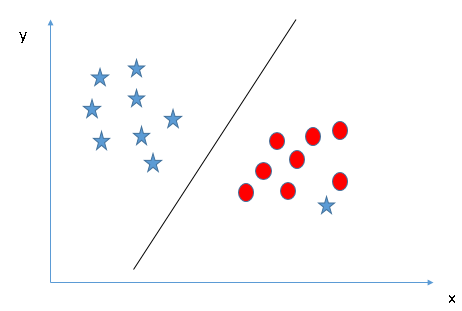 [6](https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/)


Put mathematically, SVMs construct linear separating hyperplanes in high-dimensional vector spaces. Data points are viewed as $(x⃗ ,y) $tuples, $x⃗ =(x_1,…,x_p)$ where the $x_j$ are the feature values and y is the classification (usually given as $+1$ or $−1$). Optimal classification occurs when such hyperplanes provide maximal distance to the nearest training data points. Intuitively, this makes sense, as if the points are well separated, the classification between two groups is much clearer.[7](https://www.quantstart.com/articles/Support-Vector-Machines-A-Guide-for-Beginners)


For non-linear problems, SVM employees a 'kernel trick' to learn the decision boundary. This is used for data patterns that are not linearly separable by mapping the original data into new space using the kernel function. 

Additional information about the python sklean implemation of SVMs that will be used in this notebook can be found [here](http://scikit-learn.org/stable/modules/svm.html#svm).


## 4.1 Prepare Training and Test Sets

Data is split into the labels (or 'target') we are trying to predict (whether the patient will be a show or no-show) and the features we are using to predict this target variable. 20% of the data is seperated as a test set. 

**Split data into labels and predictors.** <br/>

**Labels:** Benign/Malignent (B/M) <br/>
**Predictors:** radius, texture, perimeter, area, smoothness, compactness, concase points, concavity, symmetry and fractal dimension

In [51]:
y:data`Diagnosis_Encode
predictors:cols data_scaled
X:flip (data_scaled[predictors])

**Split data into training and test sets**

In [52]:
\t traintestsplit:{[x;y;sz]`xtrain`ytrain`xtest`ytest!raze(x;y)@\:/:(0,floor n*1-sz)_neg[n]?n:count x};
train_list:traintestsplit[x_pca;y;0.2]
-1"Length of training set ", string count train_list.xtrain;
-1"Length of test set ", string count train_list.xtest;

Length of training set 8000
Length of test set 2000


## 4.2 Model Fitting and Gridsearch
**Import required machine learning libraries**

In [53]:
svm: .p.import `sklearn.svm                     

### Gridsearch for Parameter Tuning

A gridsearch is used to identify the parameters that provide the highest prediction accuracy.


**Kernel**
Sklearn provides 3 options for kernel: linear, RBF and poly. The polynomial and RBF are especially useful when the data-points are not linearly separable.

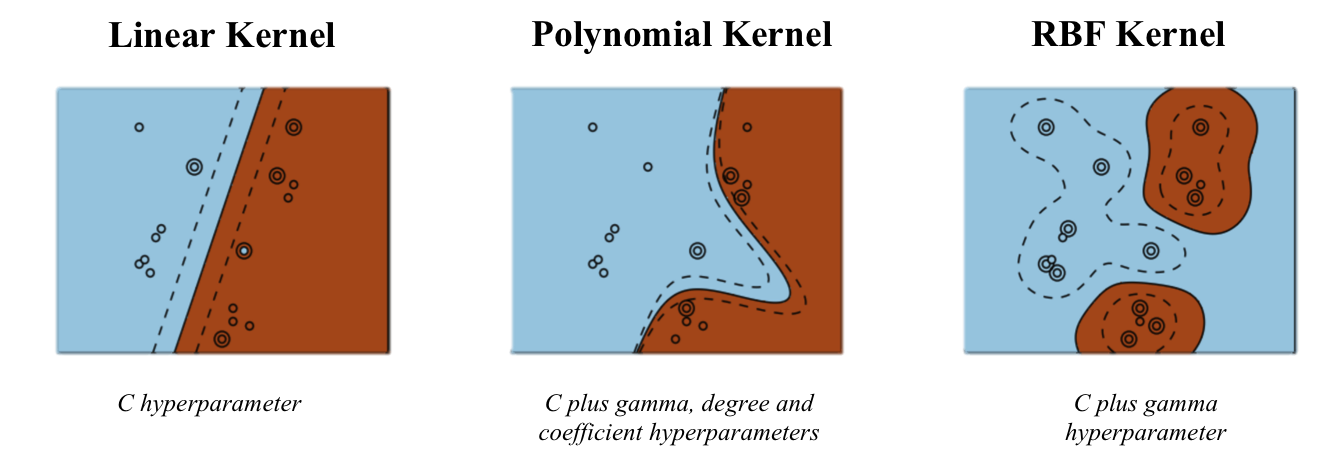

** $C$ Parameter**

The Penatly Parameter ($C$) controls the degree to which misclassifed points are penalized. A lower $C$ parameter prioritizes simplicity, supporting a softer margin and potentially leading to more misclassification. A higher $C$ can lead to overfitting. High and low C values in 2 dimmensions are illustrated below:

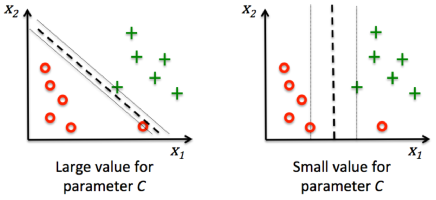

**Gamma Parameter**

Similar to the $C$ parameter, the gamma parameter or kernel coefficient dictates the level of complexity in the kernel fitting and variation can lead to overfitting or underfitting. An example is illustrated below: 

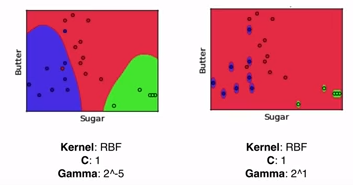


**Cross Validation**

A shuffle split it used to randomly divide the data into sections for cross validation. 

The gridsearch is evaluated by model accuracy, representing the number of false predictions.
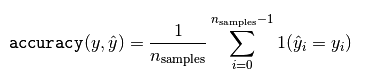


In [60]:
gridsearchcv:.p.import[`sklearn.model_selection ;`:GridSearchCV] 
shufflesplit:.p.import[`sklearn.model_selection ;`:ShuffleSplit]

SVMC:svm[`:SVC][`probability pykw 1]  // assign a class_weight of 10 to noshows

/ Create cross validation test sets
cvsets:shufflesplit[`n_splits pykw 3;`test_size pykw 0.2;`random_state pykw 0];

weight_matrix:((enlist 1)! (enlist 1);(enlist 1)! (enlist 5);(enlist 1)! (enlist 10);(enlist 1)! (enlist 15))

/creates a dictionary for C and gamma parameters
/params: `C`gamma`kernel`class_weight!((0.01 0.5 1 5 10 20)); (0.01 0.025 0.04 0.05 0.08 0.1 1 1.5);("linear";"rbf";"poly");weight_matrix)
params: (enlist `C)!(enlist(0.01 0.5 1 5 10 20)); 

/creates the grid search
gridobj:gridsearchcv[SVMC;params;`scoring pykw "accuracy";`cv pykw cvsets] /;`refit pykw "RC"]; 

/fit the grid search object to the data to compute the optimal model
gridfit:gridobj[`:fit][train_list.xtrain;train_list.ytrain];

gridScores:gridfit[`:cv_results_];
ps:gridfit[`:best_score_];
bestParams:gridfit[`:best_params_];

// builds best model
svm_model:gridfit[`:best_estimator_];

In [123]:
// run instead of grid search to apply SVM mode
svm_model:svm[`:SVC][`C pykw 1.0;`class_weight pykw (enlist 1)!enlist 5;`gamma pykw 1.5; `kernel pykw "rbf";`probability pykw 1] 
svm_model[`:fit][train_list.xtrain;train_list.ytrain];

In [61]:
-1 "Best mean cross-validated score achieved: ",(.p.repr ps );
-1 "Best model parameters  ", (.p.repr bestParams );

//Best model parameters  {'C': 1.0, 'class_weight': {1: 5}, 'gamma': 1.5, 'kernel': 'rbf'}

Best mean cross-validated score achieved: 0.98479166666666662
Best model parameters  {'C': 20.0}


## 4.3  Model Evaluation and Visulization

**Prediction Accuracy**

The performance of the SVM classifier can now be evaluated using the held-out test data. 

In [62]:
metrics:.p.import[`sklearn.metrics]      
predicted:svm_model[`:predict;<]train_list.xtest
SVMacc:accuracy[train_list.ytest;predicted]
-1"Model Accuracy: ",string SVMacc*100;

Model Accuracy: 98.85


**Confusion Matrix**

Using a confusion Matrix to visualize the prediction results, it is clear that the model is prone to predicting false negatives,  meaning that patients are predicted to be wrongly predicted to be no-shows for their appointments.  

In [ ]:
cfm:{[preds;labels]
 classes:asc distinct labels;
 :exec 0^(count each group pred)classes by label 
  from([]pred:preds;label:labels);
 }

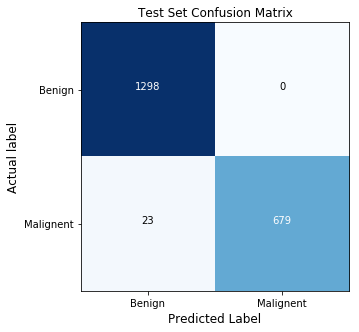

In [63]:
cnfM:cfm[predicted;train_list.ytest]
displayCM[value cnfM;`Benign`Malignent;"Test Set Confusion Matrix";()]

**Compute the models precision**

The precision is the ratio $\frac{t_p}{t_p + f_p}$ where $t_p$ is the number of true positives and $f_p$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

In [64]:
percision:metrics[`:precision_score][train_list.ytest;predicted]`
-1"Model percision: ", string percision;

Model percision: 1


In [65]:
-1"True Positive Rate:    ",string 100*cnfM[1;1]%(cnfM[1;1]+cnfM[1;0]);
-1"True Negative Rate:    ",string 100*cnfM[0;0]%(cnfM[0;0]+cnfM[0;1]);
-1"False Negative Rate:    ",string 100*cnfM[1;0]%(cnfM[1;0]+cnfM[1;1]);
-1"False Positive Rate:    ",string 100*cnfM[0;1]%(cnfM[0;1]+cnfM[0;0]);

True Positive Rate:    96.72365
True Negative Rate:    100
False Negative Rate:    3.276353
False Positive Rate:    0


** Learning Curve **

Learning curves can be used to examine the error in the model from bias and variance and determine if the model shows signs of overfitting or underfitting. Bias is the error from incorrect assumptions and causes an algorithm to miss relevant relations between the features and target (underfitting. Variance is an error from sensitvity to small fluctuations in training sets (overfitting). In practice, we would like to find a middle ground between bias and variance. 

Learning curves illustrate how the model changes as the size of the training set is increased. 

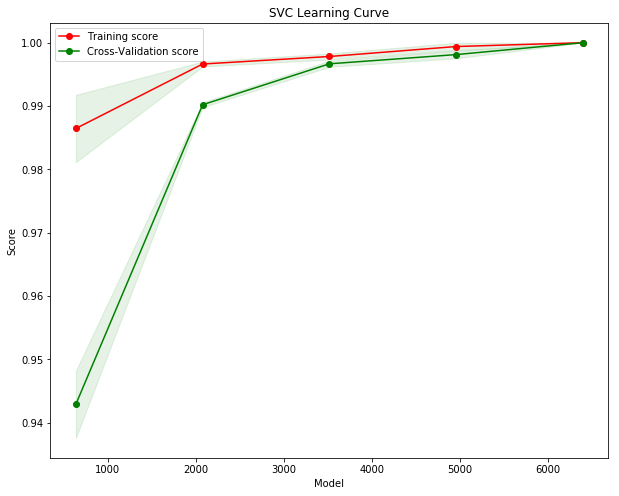

In [185]:
plotlearningcurve [svm_model;train_list;cvsets]

**Learning Curve Interpretation**

The small gap between training scores and cross-validation scores at the point of convergence indicates that the data is well generalized and is not exhibiting an overfitting bias. Additionally, we can see that after 3000 samples the model has been well trained. 

# Conclusion and Next Steps

Unsupervised clustering using k-means and support vector machines are both viable options for classifying FNA samples as benign of malignant cells. Accuracy of the models can be seen in the table below. 

| Model | Accuracy | 
| :---: | :---: |
| K-Means Clustering | 88.2% |
| SVM | 100 % |  

The SVM prediction results are likely inflated due to the repetition of data in the augemented test set, however predictions of 98 - 99 % are to be expected with this model and dataset. The analysis could be further improved by additional parameter tuning as well as general feature exploration such as outlier detection and removal.

## Further Applications for ML and Healthcare 

Artificial Intelligence (AI) and Machine Learning (ML) are redifining the way in which systems and buisnesses operate by unleashing information captured within data. Data analytics allow organizations to make increasingly informed decisions with regards to strategy, operations and more. Utilizing big data and machine learning in the healthcare industry can optimize resource allocation (e.g. money and physician time), increase diagnosis accuracy, improve patient care, and save lives

# References

[Kaggle dataset](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)  

[1. Breast Cancer Facts](http://www.nationalbreastcancer.org/breast-cancer-facts)  
[2. K-Means Clustering](https://www.linkedin.com/pulse/using-k-means-clustering-tableau-diagnose-breast-cancer-mayand-tiwari/)  
[3. Image Analysis-Assisted Diagnosis](https://dollar.biz.uiowa.edu/~street/research/cc97_02.pdf)  
[4. Breast Cancer Facts](http://www.nationalbreastcancer.org/breast-cancer-facts)  
[5. Breast Cancer Detection with Clustering Techniques](https://pdfs.semanticscholar.org/137d/bb50b86299b07a0c630fde249b30e8518c58.pdf)  
[6. Support Vector Machines Example](https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/)  
[7. Support Vector Machines Guide](https://www.quantstart.com/articles/Support-Vector-Machines-A-Guide-for-Beginners)  
[8. Scikit Learn Modules](http://scikit-learn.org/stable/modules/svm.html#svm)  

**Further Reading**

[Applying Different Machine Learning Models to
Predict Breast Cancer Risk](http://cs229.stanford.edu/proj2017/final-reports/5242363.pdf)